---------------------------------------------------------------
***Author*** : Anugraha Sinha

***Email*** : anugraha.sinha@gmail.com
------------------------------------------------------------------

## POS tagging using modified Viterbi Heuristic Based on Hidden Markov Model (HMM)
**Objectives**

We will be implementing POS Tagging prediction setup here using HMM and Viterbi Heuristic.
While simple HMM based POS tagger has fairly good accuracy, but it is strongly dependent on the ***vocabulory*** on which it is built. That is, the prediction of POS Tags for those words, which are unknown/not present in the vocabulary becomes random, or to say the first element in the list of unique POS tags.

The problem arises because of the formulation of HMM for this problem. The HMM based POS Tagger works on **emission probabilities** and **state transition probabilities**. When a word not present in the vocabulary is encountered, emission probability ( P(Word | Tag) = P(Word and Tag) / P(Tag) ) would become zero.

This leads to net probabilitity calculation as zero, and hence the first tag in the list of unique POS Tag being chosen.

We will aim to address this problem using 2 solutions

1. We will use Lexical + N-Gram based Tagger. 
    * Lexical based taggers will try and address some specific patterns which are missed in prediction
    * N-Gram Based taggers will use **Snowball Stemmer** and Unigram & Bigram tagger to for POS Tagging.
2. When a word not present in vocabulary is found, we will only state-transition probability to calculate the POS Tag.

The above strategies will be evaluated individually.

**Wordbase used** : Python NLTK Library based **Universal Treebank Tag Set for English Language**

### Data Preparation

Sourcing Libraries

In [1]:
#Importing libraries
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from datetime import datetime

Reading base data set

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

Performing initial evaluation of the length/breath of the base data we have.

In [3]:
# Lets see the data for once
print("Total Number of sentences = %d" %(len(nltk_data)))
nltk_data[:2]

Total Number of sentences = 3914


[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

#### Create a training/test set 
* Lets build a train/test set of the base data.
* We will be using 95/5 ratio for train/test, as HMM models can take a long time to predict, so to limit testing time, we take only 5% of data as test data

In [4]:
# lets build a train and test set #
train_data, test_data = train_test_split(nltk_data,test_size = 0.05,random_state=100)
print("Number of sentences in train data = %d" %(len(train_data)))
print("Number of sentences in test data = %d" %(len(test_data)))

Number of sentences in train data = 3718
Number of sentences in test data = 196


#### **build_database** function
Creates a composite database which has following important elements as a dictionary
```
1. base_data = original list of list structure of train data
2. all_word_tag_incl_dup = all (word,tag) tuples in a single list (including duplicates)
3. all_words_incl_dup = all words in a single list (including duplicates)
4. all_tags_incl_dup = all tags in a single list (including duplicates)
5. stemmed_base_data = (stemmed_word,tag) tuple list for all (word,tag) tuples in the train set
6. vocab = all unique words 
7. unique_tags = all unique tags
```
The above data is structured in a python dict() and returned by the function

In [5]:
# lets create a database of different selections from these sentences #
# IMP : since we are iterating over the complete train corpus again again, it is better that we create nested loop
#       here, rather than having a list comprehension for individual elements
def build_database(data=train_data):
    all_word_tag_incl_dup = list()
    all_words_incl_dup = list()
    all_tags_incl_dup = list()
    vocab = list()
    unique_tags = list()
    stemmed_base_data = data
    stem_obj = nltk.stem.snowball.SnowballStemmer("english")
    
    for sent_key,sent in enumerate(data):
        for word_tag_key,word_tag_tup in enumerate(sent):
            # 1. All (word,tag) combinations - including duplicates - remember order is very important, dont change the order #
            all_word_tag_incl_dup.append(word_tag_tup)
            # 2. All words (only words) - including duplicates #
            all_words_incl_dup.append(word_tag_tup[0])
            # 3. All tags (only POS tags) - including duplicates - remember order is very important, dont change order #
            all_tags_incl_dup.append(word_tag_tup[1])
            # 4. formulate a stemmed version of the word #
            stemmed_base_data[sent_key][word_tag_key] = (stem_obj.stem(word_tag_tup[0]),word_tag_tup[1])
    vocab = list(set(all_words_incl_dup))
    unique_tags = sorted(list(set(all_tags_incl_dup)),reverse=True)
    # Important point to notice here #
    # We should have the 1st tag in unique_tags as X, so that in vanilla viterbi, if a word is not found in vocab
    # it get tags as X rather than a random selection TAG every time.

    print("Unique words in train data set = %d" %(len(vocab)))
    print("Unique tags in train data set = %d" %(len(unique_tags)))
    print("Unique tags=\n%s" %(unique_tags))
    db = {"base_data" : train_data,
          "stemmed_base_data" : stemmed_base_data,
          "all_word_tag_incl_dup" : all_word_tag_incl_dup,
          "all_words_incl_dup" : all_words_incl_dup,
          "all_tags_incl_dup" : all_tags_incl_dup,
          "vocab" : vocab,
          "unique_tags" : unique_tags}
    return db

Building a composite database using build_database function

In [6]:
database = build_database()

Unique words in train data set = 12106
Unique tags in train data set = 12
Unique tags=
['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']


In [14]:
train_data[0]

[('one', 'NUM'),
 ('bright', 'ADJ'),
 ('sign', 'NOUN'),
 ('is', 'VERB'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('grow', 'VERB'),
 ('number', 'NOUN'),
 ('of', 'ADP'),
 ('women', 'NOUN'),
 ('have', 'VERB'),
 ('enter', 'VERB'),
 ('the', 'DET'),
 ('onc', 'ADV'),
 ('male-domin', 'ADJ'),
 ('field', 'NOUN'),
 (';', '.'),
 ('more', 'ADJ'),
 ('than', 'ADP'),
 ('a', 'DET'),
 ('third', 'ADJ'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('ringer', 'NOUN'),
 ('today', 'NOUN'),
 ('are', 'VERB'),
 ('women', 'NOUN'),
 ('.', '.')]

#### calculate_prob_word_given_tag function
```
Builds the emission probability for a word, given POS Tag
```

In [0]:
# Calculate Emission Probabilities #
def calculate_prob_word_given_tag(word,tag,data=database):
    # P(W|T) = count(W and T) / (count(T))
    count_word_and_tag = len(list(filter(lambda x : x[0] == word and x[1] == tag,data["all_word_tag_incl_dup"])))
    count_times_tag = len(list(filter(lambda x : x == tag,data["all_tags_incl_dup"])))
    return count_word_and_tag/count_times_tag

In [0]:
calculate_prob_word_given_tag("Pierre","NOUN")

3.631213914811722e-05

#### calculate_transition_prob function
```
Calculated the transition probability from state (POST TAG t1) -> state (POS TAG t2) in an HMM structure.
function signature expects tags as follows
calculate_transition_prob(t2,t1)
```

In [0]:
# Calculate Transition Probabilities #
def calculate_transition_prob(t2,t1,data=database):
    # P(T2/T1) = count(T2 ahead of T1)  /  count(T1)
    count_t2_ahead_t1 = len(list(filter(lambda x : data["all_tags_incl_dup"][x] == t1 and data["all_tags_incl_dup"][x+1] == t2,np.arange(0,len(data["all_tags_incl_dup"])-1))))
    count_t1 = len(list(filter(lambda x : x == t1,data["all_tags_incl_dup"])))
    return count_t2_ahead_t1 / count_t1

In [0]:
calculate_transition_prob("NOUN","ADJ")

0.7009009009009008

#### state (tag) transition matrix
Lets create a state transition matrix. There are 12 unique tags in the dataset, so we can build 12X12 state transition matrix signifying the probability of transition from 1 tag to another tag

**Important**

In this state transition matrix
```
rows    = T2 Tag
columns = T1 Tag
```

We will save this state transisition matrix in the main database python dict() also.

In [0]:
# Lets create tag to tag matrix, having t2 and t1 given #
# Rows = T2 and columns = T1
tag_transition_df = pd.DataFrame(np.array([calculate_transition_prob(t2,t1) for t2 in database["unique_tags"] for t1 in database["unique_tags"]]).reshape(len(database["unique_tags"]),len(database["unique_tags"])),
                                 columns=database["unique_tags"],index=database["unique_tags"])
database["tag_transition_df"] = tag_transition_df

In [0]:
tag_transition_df

,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.
X,0.074433,0.218438,0.013123,0.092720,0.211824,0.028868,0.045323,0.008809,0.023302,0.034984,0.020311,0.026908
VERB,0.204571,0.168744,0.405184,0.484291,0.016934,0.146955,0.040394,0.155308,0.344541,0.008481,0.011794,0.088708
PRT,0.184891,0.031427,0.001969,0.012261,0.026144,0.043357,0.000240,0.003709,0.014314,0.001484,0.010156,0.002511
PRON,0.055705,0.035916,0.017717,0.007663,0.001485,0.004721,0.003727,0.058414,0.015646,0.069119,0.000491,0.065208
NUM,0.002857,0.022448,0.056102,0.007280,0.184195,0.009550,0.021640,0.042188,0.031625,0.061910,0.020803,0.081353
NOUN,0.062371,0.111386,0.245735,0.211494,0.352347,0.264280,0.637293,0.350487,0.031625,0.321213,0.700901,0.222531
DET,0.055229,0.133292,0.101050,0.009195,0.003862,0.013363,0.005771,0.118683,0.069907,0.323969,0.004914,0.173558
CONJ,0.010316,0.005186,0.002297,0.004981,0.013072,0.042921,0.000481,0.000464,0.006991,0.000848,0.016052,0.058032
ADV,0.025393,0.082050,0.010171,0.034100,0.002674,0.016813,0.012623,0.053778,0.077230,0.013357,0.004914,0.052292
ADP,0.144898,0.091184,0.019357,0.023372,0.035056,0.177058,0.009618,0.053778,0.119507,0.017492,0.078624,0.092206


Lets see a heatmap of the state transistion matrix

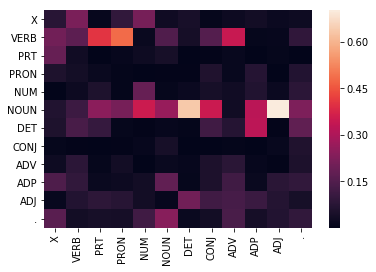

In [0]:
# Building a heatmap #
sns.heatmap(tag_transition_df)

state transition matrix for those POS TAGS which have more than 50% probability.

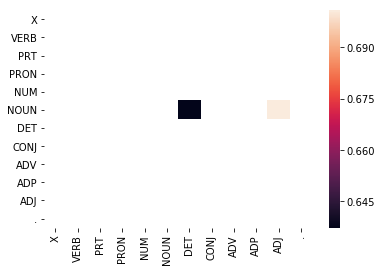

In [0]:
sns.heatmap(tag_transition_df[tag_transition_df>=0.5])

```
DET -> NOUN = 0.637293 ~ For eg : The man, A dog etc. ~ Intuitively also this seems quite right
ADJ -> NOUN = 0.700901 ~ For eg : Tall man, small child ~ Intuitively also this seems quite right
```

### Build the vanilla Viterbi based POS tagger
vanilla_viterbi_pos_tagger function, utilized the functions built above to predict tags

In [0]:
def vanilla_viterbi_pos_tagger(words,db=None):
    if not db:
        db = build_database(data_for_training)
    states = list()
    for key,word in enumerate(words):
        probs = list()
        for t2 in db["unique_tags"]:
            if key == 0:
                t1 = "."
            else:
                t1=states[-1]
            # Some debugging statements for performance
            #s = datetime.now()
            emission_prob = calculate_prob_word_given_tag(word,t2,db)
            #e = datetime.now() - s
            #print("For word = %s, emission prob time = %f" %(word,(e.seconds + (e.microseconds/1e6))))
            #s = datetime.now()
            transition_prob = db["tag_transition_df"].loc[t2,t1]
            #e = datetime.now() - s
            #print("For word = %s, trans prob time = %f" %(word,(e.seconds + (e.microseconds/1e6))))
            state_probability = emission_prob * transition_prob
            probs.append(state_probability)
        states.append(db["unique_tags"][np.where(np.array(probs) == max(probs))[0][0]])
    return zip(words,states)

1. We create a ```test_data_df``` which will have the word, actual tag and the predicted tags we will create going forward
2. vanilla_viterbi predictions will be saved in ```test_data_df``` under column ```vanilla_pred_tag```

In [0]:
test_data_df = pd.DataFrame({"word" : [ word[0] for sent in test_data for word in sent],
                             "actual_tag" : [word[1] for sent in test_data for word in sent]})
predicted_state = list()
for index,sent in enumerate(test_data):
    print("Working on index = %d" %(index))
    pred_tup = vanilla_viterbi_pos_tagger([tup[0] for tup in sent],database)
    for tup in pred_tup:
        predicted_state.append(tup[1])
test_data_df = test_data_df.assign(vanilla_pred_tag = predicted_state)

Working on index = 0
Working on index = 1
Working on index = 2
Working on index = 3
Working on index = 4
Working on index = 5
Working on index = 6
Working on index = 7
Working on index = 8
Working on index = 9
Working on index = 10
Working on index = 11
Working on index = 12
Working on index = 13
Working on index = 14
Working on index = 15
Working on index = 16
Working on index = 17
Working on index = 18
Working on index = 19
Working on index = 20
Working on index = 21
Working on index = 22
Working on index = 23
Working on index = 24
Working on index = 25
Working on index = 26
Working on index = 27
Working on index = 28
Working on index = 29
Working on index = 30
Working on index = 31
Working on index = 32
Working on index = 33
Working on index = 34
Working on index = 35
Working on index = 36
Working on index = 37
Working on index = 38
Working on index = 39
Working on index = 40
Working on index = 41
Working on index = 42
Working on index = 43
Working on index = 44
Working on index = 4

In [0]:
test_data_df.head()

,actual_tag,word,vanilla_pred_tag
0,NOUN,Investors,NOUN
1,VERB,took,VERB
2,NOUN,advantage,NOUN
3,ADP,of,ADP
4,NOUN,Tuesday,NOUN


#### PREDICTION EVALUATION REPORT - VANILLA VITERBI HEURISTIC POS TAGGER

In [0]:
print(classification_report(test_data_df["actual_tag"],test_data_df["vanilla_pred_tag"]))
print("Average Accuracy = %f" %(accuracy_score(test_data_df["actual_tag"],test_data_df["vanilla_pred_tag"])))
viterbi_vanilla_pred_result = pd.DataFrame(confusion_matrix(test_data_df["actual_tag"],test_data_df["vanilla_pred_tag"],labels=database["unique_tags"]),
                                           columns = database["unique_tags"],index=database["unique_tags"]).assign(accuracy = [ test_data_df[(test_data_df["actual_tag"] == tag) & (test_data_df["vanilla_pred_tag"] == tag)].shape[0] / test_data_df[test_data_df["actual_tag"] == tag].shape[0] for tag in database["unique_tags"]])
print("Rows = Actual Tags\nColumns = Predicted Tag")
viterbi_vanilla_pred_result

             precision    recall  f1-score   support

          .       1.00      1.00      1.00       566
        ADJ       0.87      0.74      0.80       292
        ADP       0.94      0.98      0.96       424
        ADV       0.92      0.82      0.87       167
       CONJ       1.00      1.00      1.00       108
        DET       0.98      0.96      0.97       407
       NOUN       0.97      0.85      0.91      1328
        NUM       0.99      0.81      0.89       180
       PRON       0.98      1.00      0.99       127
        PRT       0.94      0.97      0.96       171
       VERB       0.95      0.88      0.91       645
          X       0.51      1.00      0.68       312

avg / total       0.93      0.91      0.91      4727

Average Accuracy = 0.905014
Rows = Actual Tags
Columns = Predicted Tag


,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.,accuracy
X,312,0,0,0,0,0,0,0,0,0,0,0,1.000000
VERB,55,565,1,0,0,19,0,0,0,0,5,0,0.875969
PRT,0,0,166,0,0,0,0,0,2,3,0,0,0.970760
PRON,0,0,0,127,0,0,0,0,0,0,0,0,1.000000
NUM,34,0,0,0,145,0,1,0,0,0,0,0,0.805556
NOUN,151,26,0,0,1,1132,3,0,0,0,15,0,0.852410
DET,1,0,0,2,0,1,389,0,0,14,0,0,0.955774
CONJ,0,0,0,0,0,0,0,108,0,0,0,0,1.000000
ADV,4,0,3,0,0,2,2,0,137,8,11,0,0.820359
ADP,1,0,4,0,0,0,1,0,3,415,0,0,0.978774


Tags whose accuracy is less than 90% accuracy

In [0]:
viterbi_vanilla_pred_result[viterbi_vanilla_pred_result["accuracy"] < 0.9]

,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.,accuracy
VERB,55,565,1,0,0,19,0,0,0,0,5,0,0.875969
NUM,34,0,0,0,145,0,1,0,0,0,0,0,0.805556
NOUN,151,26,0,0,1,1132,3,0,0,0,15,0,0.852410
ADV,4,0,3,0,0,2,2,0,137,8,11,0,0.820359
ADJ,51,1,2,0,0,14,0,0,7,1,216,0,0.739726


#### Analysis of Vanilla Viterbi POS Tagger 

1. Maximum mis classification are getting tagged as "X"
2. "X" is the first tag our list of unique_tags

Lets check the words which are wrongly predicted as "X", if they were present in the vocab

In [0]:
# Major mis predictions are getting tagged as X - Unknown words
# Lets check if these words are missing in vocab or there is mis calculation in HMM algorithm #
print("Words wrongly predicted, which are present in vocab =")
list(filter(lambda x : x in database["vocab"], np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["vanilla_pred_tag"] == "X")]["word"])))

Words wrongly predicted, which are present in vocab =


[]

So the words being tagged incorrectly are the ones which are not present in the vocab.

Lets look at the words which were tagged incorrectly.

In [0]:
# So the main problem is that the words which are not present, are being predicted as X #
# So we need to form a policy which could enable missing words to be correctly predicted #
# Let see the words which are wrongly predicted
print("Number of words missing in vocab and wrongly predicted as \"X\" = %d" %(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["vanilla_pred_tag"] == "X")].shape[0]))
print("Words which are wrongly predicted as \"X\"")
np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["vanilla_pred_tag"] == "X")]["word"])

Number of words missing in vocab and wrongly predicted as "X" = 297
Words which are wrongly predicted as "X"


array(["'82", '11.95', '115', '12.52', '126,000', '13.90', '14.75',
       '141.9', '143.08', '143.93', '149.9', '150.00', '1997', '221.4',
       '240-page', '27-year', '29year', '3.19', '306', '472', '51.6',
       '550,000', '59-year-old', '609', '618.1', '62-year-old',
       '63-year-old', '692', '77.6', '8.75', '84-year-old', '858,000',
       '879', '88.32', '89.7', '94.8', '960', '99.1', 'ACCOUNT',
       'APPEARS', 'Above', 'Aerospace', 'Ala', 'Anderson', 'Anku',
       'Aquino', 'Birmingham', 'Bolivia', 'Braun', 'Brussels',
       'Californian', 'Cataracts', 'Chilver', 'Clays', 'Connections',
       'Corazon', 'CoreStates', 'DISCOUNT', 'DeFazio', 'ECONOMIC',
       'Earle', 'Five', 'Four', 'GROWTH', 'Gardner', 'Green', 'Hubbard',
       'Ilminster', 'Indexing', 'Iran-Contra', 'Kelli', 'Ketchum',
       'Kirkpatrick', 'Landrieu', 'Left', 'Louisiana-Pacific', 'Lucille',
       'Malta', 'Mead', 'Metal', 'Milan', 'Mont', 'Moon', 'N.Y', 'NCNB',
       'NEW', 'Next', 'Nylev', 'Old-

Looking at the above list,, following patterns can be seen
1. Numbers are being incorrectly tagged. We can solve this using a regex tagger as being NUM
2. Words starting with CAPITAL letter, which are not present in the vocab are being tagged incorrectly. We can solve this also by using regex based tagger as being NOUN.

### Solve the problem of Unknown Words

### STRATEGY 1 (Lexical + Syntactic Based)
```viterbi_backoff``` function acts as a backoff function for vanilla viterbi. This means, if a word is not found in the vocab then it uses following strategy for tagging the word

**Check 1** : The word is checked using regex tagger to be a number, if true then ```NUM``` Tag is returned

``` back's off too```

**Check 2** :  The word is checked using regex tagger if it starts with a capital letter, if true, then ```NOUN``` is returned

``` back's off too```

**Check 3** : It uses **Snowball stemmer** based Bigram tagger to tag the word

``` back's off too```

**Check 4** :  It uses **Snowball stemmer** based Unigram tagger to tag the word

``` back's off too```

**Check 5** :  If none of the above works, then it returns ```X``` again.

### STRATEGY 2 (Use only transition probability)
Another strategy is to use only transition probability when a word is not present in the vocab.

For realizing both the above strategy, we will modify the viterbi pos tagger function as mentioned below.

In [0]:
def viterbi_backoff(test_word,db):
    stem_obj = nltk.stem.snowball.SnowballStemmer("english")
    test_word_stemmed = stem_obj.stem(test_word)
    
    default_reg_ex_pattern = [('.*','X')]
    default_reg_ex_tagger = nltk.RegexpTagger(default_reg_ex_pattern)
    
    unigram_tagger = nltk.UnigramTagger(db["stemmed_base_data"],backoff=default_reg_ex_tagger)
    
    bigram_tagger = nltk.BigramTagger(db["stemmed_base_data"],backoff=unigram_tagger)
    
    reg_ex_pattern = [('^[0-9]+.*','NUM'),
                      ('^[A-Z]+[\-\.\_\\]*[A-z]+$',"NOUN")] # remember : we do not add a default case,as we need to know if the prediction failed
    regex_tagger = nltk.RegexpTagger(reg_ex_pattern)
    
    tag_pred = regex_tagger.tag([test_word])
    
    if not tag_pred[0][1]:
        tag_pred = bigram_tagger.tag([test_word_stemmed])
    
    if tag_pred[0][1] == "X":
        return False,tag_pred[0][1]
    else:
        return True,tag_pred[0][1]

In [0]:
def modified_vanilla_viterbi_pos_tagger(words,db=None,strategy="backoff"):
    if not db:
        db = build_database(data_for_training)
    states = list()
    # debug #
    #print("using strategy = %s" %(strategy))
    for key,word in enumerate(words):
        if word in db["vocab"] or strategy == "unknown_use_transition_only":
            probs = list()
            for t2 in db["unique_tags"]:
                if key == 0:
                    t1 = "."
                else:
                    t1=states[-1]
                if word in db["vocab"]:
                    emission_prob = calculate_prob_word_given_tag(word,t2,db)
                else:
                    #print("force selection emission = 1 for word = %s" %(word))
                    emission_prob = 1.0
                transition_prob = db["tag_transition_df"].loc[t2,t1]
                state_probability = emission_prob * transition_prob
                probs.append(state_probability)
            states.append(db["unique_tags"][np.where(np.array(probs) == max(probs))[0][0]])
        else:
            #print("backing off for word = %s" %(word))
            result, tag_pred = viterbi_backoff(word,db)
            states.append(tag_pred)
    return zip(words,states)

Lets try modified viterbi on a test sentence.

*Test sentence = "It rained 223mm in Japan yesterday, very heavy rainfall"*

In [0]:
original_sent = "It rained 223mm in Japan yesterday, very heavy rainfall"
print("Original sentence = %s" %(original_sent))
print("\nUsing vanilla viterbi, the tags are:")
for x in vanilla_viterbi_pos_tagger(original_sent.split(),database):
    print(x)
print("\nUsing modified viterbi (strategy = backoff), the tags are:")
for x in modified_vanilla_viterbi_pos_tagger("It rained 223mm in Japan yesterday, very heavy rainfall".split(),database,strategy="backoff"):
    print(x)
print("\n Using modified viterbi (strategy = unknown_use_transition_only), the tags are:")
for x in modified_vanilla_viterbi_pos_tagger("It rained 223mm in Japan yesterday, very heavy rainfall".split(),database,strategy="unknown_use_transition_only"):
    print(x)

Original sentence = It rained 223mm in Japan yesterday, very heavy rainfall

Using vanilla viterbi, the tags are:
('It', 'PRON')
('rained', 'X')
('223mm', 'X')
('in', 'ADP')
('Japan', 'NOUN')
('yesterday,', 'X')
('very', 'ADV')
('heavy', 'ADJ')
('rainfall', 'X')

Using modified viterbi (strategy = backoff), the tags are:
('It', 'PRON')
('rained', 'NOUN')
('223mm', 'NUM')
('in', 'ADP')
('Japan', 'NOUN')
('yesterday,', 'X')
('very', 'ADV')
('heavy', 'ADJ')
('rainfall', 'X')

 Using modified viterbi (strategy = unknown_use_transition_only), the tags are:
('It', 'PRON')
('rained', 'VERB')
('223mm', 'X')
('in', 'ADP')
('Japan', 'NOUN')
('yesterday,', 'NOUN')
('very', 'ADV')
('heavy', 'ADJ')
('rainfall', 'NOUN')


**Lets run on test data using ```strategy="backoff"```**

In [0]:
predicted_state = list()
for index,sent in enumerate(test_data):
    print("Working on index = %d" %(index))
    pred_tup = modified_vanilla_viterbi_pos_tagger([tup[0] for tup in sent],database,strategy="backoff")
    for tup in pred_tup:
        predicted_state.append(tup[1])

Working on index = 0
Working on index = 1
Working on index = 2
Working on index = 3
Working on index = 4
Working on index = 5
Working on index = 6
Working on index = 7
Working on index = 8
Working on index = 9
Working on index = 10
Working on index = 11
Working on index = 12
Working on index = 13
Working on index = 14
Working on index = 15
Working on index = 16
Working on index = 17
Working on index = 18
Working on index = 19
Working on index = 20
Working on index = 21
Working on index = 22
Working on index = 23
Working on index = 24
Working on index = 25
Working on index = 26
Working on index = 27
Working on index = 28
Working on index = 29
Working on index = 30
Working on index = 31
Working on index = 32
Working on index = 33
Working on index = 34
Working on index = 35
Working on index = 36
Working on index = 37
Working on index = 38
Working on index = 39
Working on index = 40
Working on index = 41
Working on index = 42
Working on index = 43
Working on index = 44
Working on index = 4

In [0]:
test_data_df = test_data_df.assign(backoff_tag_pred = predicted_state)

#### Analysis of modified viterbi (```strategy = backoff```)

In [0]:
print(classification_report(test_data_df["actual_tag"],test_data_df["backoff_tag_pred"]))
print("Average Accuracy = %f" %(accuracy_score(test_data_df["actual_tag"],test_data_df["backoff_tag_pred"])))
viterbi_backoff_pred_result = pd.DataFrame(confusion_matrix(test_data_df["actual_tag"],test_data_df["backoff_tag_pred"],labels=database["unique_tags"]),
                                           columns = database["unique_tags"],index=database["unique_tags"]).assign(accuracy = [ test_data_df[(test_data_df["actual_tag"] == tag) & (test_data_df["backoff_tag_pred"] == tag)].shape[0] / test_data_df[test_data_df["actual_tag"] == tag].shape[0] for tag in database["unique_tags"]])
viterbi_backoff_pred_result

             precision    recall  f1-score   support

          .       1.00      1.00      1.00       566
        ADJ       0.86      0.74      0.80       292
        ADP       0.94      0.98      0.96       424
        ADV       0.93      0.82      0.87       167
       CONJ       1.00      1.00      1.00       108
        DET       0.98      0.96      0.97       407
       NOUN       0.96      0.92      0.94      1328
        NUM       0.96      0.98      0.97       180
       PRON       0.98      1.00      0.99       127
        PRT       0.95      0.97      0.96       171
       VERB       0.95      0.91      0.93       645
          X       0.73      1.00      0.85       312

avg / total       0.94      0.94      0.94      4727

Average Accuracy = 0.936112


,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.,accuracy
X,312,0,0,0,0,0,0,0,0,0,0,0,1.000000
VERB,24,584,1,0,0,29,0,0,0,0,7,0,0.905426
PRT,0,0,166,0,0,0,0,0,2,3,0,0,0.970760
PRON,0,0,0,127,0,0,0,0,0,0,0,0,1.000000
NUM,1,0,0,0,176,2,1,0,0,0,0,0,0.977778
NOUN,49,30,0,0,1,1228,3,0,0,0,17,0,0.924699
DET,1,0,0,2,0,1,389,0,0,14,0,0,0.955774
CONJ,0,0,0,0,0,0,0,108,0,0,0,0,1.000000
ADV,3,0,2,0,0,2,2,0,137,9,12,0,0.820359
ADP,0,0,4,0,0,1,1,0,3,415,0,0,0.978774


The net accuracy has increased from 90.5% to 93.6%.

Let look at the words predicted as X, were they present in vocab?

In [0]:
print("Words wrongly predicted, which are present in vocab =")
list(filter(lambda x : x in database["vocab"], np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["backoff_tag_pred"] == "X")]["word"])))

Words wrongly predicted, which are present in vocab =


[]

So all words predicted as "X", were not present in the Vocab.

In [0]:
print("Number of words missing in vocab and wrongly predicted as \"X\" = %d" %(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["backoff_tag_pred"] == "X")].shape[0]))
print("Words which are wrongly predicted as \"X\"")
np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["backoff_tag_pred"] == "X")]["word"])

Number of words missing in vocab and wrongly predicted as "X" = 114
Words which are wrongly predicted as "X"


array(["'82", 'abortion-related', 'administer', 'aftereffects', 'alumni',
       'amazingly', 'ankle', 'arrows', 'athletic', 'awaits', 'barometer',
       'behemoth', 'blinks', 'bricks', 'burn', 'burned', 'cancer-causing',
       'cardiovascular', 'cavernous', 'chest', 'clamped',
       'cleaner-burning', 'cleanup', 'construed', 'criteria',
       'descending', 'diagnosed', 'diagram', 'directorship', 'discretion',
       'dreamed', 'dust-up', 'emasculate', 'espouse', 'ethanol',
       'executive-office', 'facade', 'faded', 'father-in-law',
       'faultlessly', 'fifth-largest', 'finest', 'flirted', 'foam',
       'glory', 'grandstander', 'heebie-jeebies', 'heirs', 'high-rise',
       'highest-pitched', 'housewife', 'illustrates', 'improbable',
       'incisions', 'infectious', 'information-services', 'inkling',
       'insane', 'insanity', 'insurance-company', 'intoxication',
       'intricate', 'investor-relations', 'jeopardy', 'jolts', 'le',
       'loose', 'luxury', 'malnutrition', 

So the number of words wrongly predicted as reduced from 
* vanilla viterbi -> 297 mis classifications 
* modified viterby - strategy backoff -> 114 mis classification

**Lets run on test data using ```strategy="unknown_use_transition_only"```**

In [0]:
predicted_state = list()
for index,sent in enumerate(test_data):
    print("Working on index = %d" %(index))
    pred_tup = modified_vanilla_viterbi_pos_tagger([tup[0] for tup in sent],database,strategy="unknown_use_transition_only")
    for tup in pred_tup:
        predicted_state.append(tup[1])

Working on index = 0
Working on index = 1
Working on index = 2
Working on index = 3
Working on index = 4
Working on index = 5
Working on index = 6
Working on index = 7
Working on index = 8
Working on index = 9
Working on index = 10
Working on index = 11
Working on index = 12
Working on index = 13
Working on index = 14
Working on index = 15
Working on index = 16
Working on index = 17
Working on index = 18
Working on index = 19
Working on index = 20
Working on index = 21
Working on index = 22
Working on index = 23
Working on index = 24
Working on index = 25
Working on index = 26
Working on index = 27
Working on index = 28
Working on index = 29
Working on index = 30
Working on index = 31
Working on index = 32
Working on index = 33
Working on index = 34
Working on index = 35
Working on index = 36
Working on index = 37
Working on index = 38
Working on index = 39
Working on index = 40
Working on index = 41
Working on index = 42
Working on index = 43
Working on index = 44
Working on index = 4

In [0]:
test_data_df = test_data_df.assign(only_transition_tag_pred = predicted_state)

In [0]:
print(classification_report(test_data_df["actual_tag"],test_data_df["only_transition_tag_pred"]))
print("Average Accuracy = %f" %(accuracy_score(test_data_df["actual_tag"],test_data_df["only_transition_tag_pred"])))
viterbi_only_trans_pred_result = pd.DataFrame(confusion_matrix(test_data_df["actual_tag"],test_data_df["only_transition_tag_pred"],labels=database["unique_tags"]),
                                           columns = database["unique_tags"],index=database["unique_tags"]).assign(accuracy = [ test_data_df[(test_data_df["actual_tag"] == tag) & (test_data_df["only_transition_tag_pred"] == tag)].shape[0] / test_data_df[test_data_df["actual_tag"] == tag].shape[0] for tag in database["unique_tags"]])
viterbi_only_trans_pred_result

             precision    recall  f1-score   support

          .       1.00      1.00      1.00       566
        ADJ       0.88      0.74      0.80       292
        ADP       0.94      0.98      0.96       424
        ADV       0.92      0.83      0.87       167
       CONJ       1.00      1.00      1.00       108
        DET       0.91      0.96      0.93       407
       NOUN       0.92      0.94      0.93      1328
        NUM       0.99      0.81      0.89       180
       PRON       0.98      1.00      0.99       127
        PRT       0.95      0.97      0.96       171
       VERB       0.91      0.91      0.91       645
          X       0.92      0.97      0.95       312

avg / total       0.93      0.93      0.93      4727

Average Accuracy = 0.933150


,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.,accuracy
X,304,3,0,0,0,2,3,0,0,0,0,0,0.974359
VERB,14,584,1,0,0,39,2,0,0,0,5,0,0.905426
PRT,0,0,166,0,0,0,0,0,2,3,0,0,0.970760
PRON,0,0,0,127,0,0,0,0,0,0,0,0,1.000000
NUM,0,5,0,0,145,23,7,0,0,0,0,0,0.805556
NOUN,7,37,0,0,1,1252,16,0,0,0,15,0,0.942771
DET,0,0,0,2,0,2,389,0,0,14,0,0,0.955774
CONJ,0,0,0,0,0,0,0,108,0,0,0,0,1.000000
ADV,1,1,2,0,0,4,2,0,138,8,11,0,0.826347
ADP,0,0,4,0,0,1,1,0,3,415,0,0,0.978774


The net accuracy has increased from 90.5% to 93.3%. (Vs vanilla)

The net accuracy for modified vanilla with (strategy = "backoff") = 93.6%

So both strategies give approximately same accuracy results

Let look at the words predicted as X, were they present in vocab?

In [0]:
print("Words wrongly predicted, which are present in vocab =")
list(filter(lambda x : x in database["vocab"], np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["only_transition_tag_pred"] == "X")]["word"])))

Words wrongly predicted, which are present in vocab =


[]

So all words predicted as "X", were not present in the Vocab.

In [0]:
print("Number of words missing in vocab and wrongly predicted as \"X\" = %d" %(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["only_transition_tag_pred"] == "X")].shape[0]))
print("Words which are wrongly predicted as \"X\"")
np.unique(test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["only_transition_tag_pred"] == "X")]["word"])

Number of words missing in vocab and wrongly predicted as "X" = 26
Words which are wrongly predicted as "X"


array(['Bolivia', 'Braun', 'Earle', 'Green', 'Landrieu',
       'abortion-related', 'amazingly', 'burned', 'clamped', 'construed',
       'cultivated', 'delayed', 'disapproved', 'emasculate', 'faded',
       'flirted', 'foam', 'hotels', 'inserted', 'non-biodegradable',
       'outlawed', 'preclinical', 'pushes', 'shown', 'tailor-made',
       'wrestling'], dtype=object)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [0]:
vanilla_acc = accuracy_score(test_data_df["actual_tag"],test_data_df["vanilla_pred_tag"])
backoff_acc = accuracy_score(test_data_df["actual_tag"],test_data_df["backoff_tag_pred"])
trans_acc = accuracy_score(test_data_df["actual_tag"],test_data_df["only_transition_tag_pred"])

a = test_data_df[(test_data_df["actual_tag"] != "X") & (test_data_df["vanilla_pred_tag"] == "X")]
backoff_unknown_corrected = a[a["actual_tag"] == a["backoff_tag_pred"]].shape[0]
trans_unknown_corrected = a[a["actual_tag"] == a["only_transition_tag_pred"]].shape[0]
backoff_unknown_wrongly_pred = a[a["actual_tag"] != a["backoff_tag_pred"]].shape[0]
trans_unknown_wrongly_pred = a[a["actual_tag"] != a["only_transition_tag_pred"]].shape[0]

print("Total number of words not present in vocab which were wrongly predicted as \"X\" = %d" %(a.shape[0]))

pd.DataFrame({"Acc" : [vanilla_acc,backoff_acc,trans_acc],
              "Unknown_correctly_pred" : [np.nan,backoff_unknown_corrected,trans_unknown_corrected],
              "Unknown_wrongly_pred" : [np.nan,backoff_unknown_wrongly_pred,trans_unknown_wrongly_pred]},index=["Vanilla Viterbi","Modified Viterbi(Regex+Lexical)","Modified Viterbi(only transition prob)"])

Total number of words not present in vocab which were wrongly predicted as "X" = 297


,Acc,Unknown_correctly_pred,Unknown_wrongly_pred
Vanilla Viterbi,0.905014,NaN,NaN
Modified Viterbi(Regex+Lexical),0.936112,143.0,154.0
Modified Viterbi(only transition prob),0.933150,138.0,159.0


Clearly, Regex+Lexical based Modified viterbi seems to be doing the job better because
1. Number of unknowns predicted correctly are more.
2. Number of unknowns which are wrongly predicted as are also low.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [0]:
print("correct by backoff strategy")
a = test_data_df[test_data_df["actual_tag"] != test_data_df["vanilla_pred_tag"]]
print("Number of correction made = %d/%d ~ %f" %(a[a["actual_tag"] == a["backoff_tag_pred"] ].shape[0],
                                                 a.shape[0],
                                                 a[a["actual_tag"] == a["backoff_tag_pred"] ].shape[0]/a.shape[0]))
print("\nWords which were corrected by backoff:")
print(np.unique(a[a["actual_tag"] == a["backoff_tag_pred"] ]["word"]))

correct by backoff strategy
Number of correction made = 147/449 ~ 0.327394

Words which were corrected by backoff:
['11.95' '115' '12.52' '126,000' '13.90' '14.75' '141.9' '143.08' '143.93'
 '149.9' '150.00' '1997' '221.4' '3.19' '306' '472' '51.6' '550,000' '609'
 '618.1' '692' '77.6' '8.75' '858,000' '879' '88.32' '89.7' '94.8' '960'
 '99.1' 'ACCOUNT' 'Aerospace' 'Ala' 'Anderson' 'Anku' 'Aquino'
 'Birmingham' 'Bolivia' 'Braun' 'Brussels' 'Californian' 'Cataracts'
 'Chilver' 'Clays' 'Connections' 'Corazon' 'CoreStates' 'DISCOUNT'
 'DeFazio' 'Earle' 'GROWTH' 'Gardner' 'Green' 'Hubbard' 'Ilminster'
 'Indexing' 'Iran-Contra' 'Kelli' 'Ketchum' 'Kirkpatrick' 'Landrieu'
 'Louisiana-Pacific' 'Lucille' 'Malta' 'Mead' 'Metal' 'Milan' 'Mont'
 'Moon' 'Municipal' 'N.Y' 'NCNB' 'NEW' 'Nylev' 'Old-House' 'Palmer'
 'Paper' 'Paris' 'Peck' 'Philippine' 'Preston' 'R.D.' 'Researchers' 'S.A'
 'Sandoz' 'Silverman' 'Somerset' 'Spending' 'Spiro' 'Sumitomo' 'Tiny'
 'Tip' 'Tots' 'Trans' 'Video' 'Vos' 'Wick' 'Z

In [0]:
print("correct by using only transition probability for unknown words")
a = test_data_df[test_data_df["actual_tag"] != test_data_df["vanilla_pred_tag"]]
print("Number of correction made = %d/%d ~ %f" %(a[a["actual_tag"] == a["only_transition_tag_pred"] ].shape[0],
                                                 a.shape[0],
                                                 a[a["actual_tag"] == a["only_transition_tag_pred"] ].shape[0]/a.shape[0]))
print("\nWords which were corrected by using only transition prob:")
print(np.unique(a[a["actual_tag"] == a["only_transition_tag_pred"] ]["word"]))

correct by using only transition probability for unknown words
Number of correction made = 142/449 ~ 0.316258

Words which were corrected by using only transition prob:
['ACCOUNT' 'Aerospace' 'Ala' 'Anderson' 'Anku' 'Aquino' 'Birmingham'
 'Brussels' 'Californian' 'Cataracts' 'Chilver' 'Clays' 'Connections'
 'Corazon' 'CoreStates' 'DISCOUNT' 'DeFazio' 'GROWTH' 'Gardner' 'Hubbard'
 'Indexing' 'Iran-Contra' 'Ketchum' 'Kirkpatrick' 'Left'
 'Louisiana-Pacific' 'Lucille' 'Mead' 'Metal' 'Milan' 'Mont' 'Municipal'
 'N.Y' 'NCNB' 'NEW' 'Nylev' 'Old-House' 'Paper' 'Paris' 'Peck'
 'Philippine' 'Preston' 'R.D.' 'Researchers' 'S.A' 'Sandoz' 'Silverman'
 'Sit' 'Somerset' 'Spending' 'Spiro' 'Sumitomo' 'Tiny' 'Tip' 'Tots'
 'Video' 'Vos' 'Wick' 'Z.' 'accountants' 'adults' 'aftereffects' 'argues'
 'attendance' 'barometer' 'behemoth' 'bombers' 'bricks' 'broadened'
 'chest' 'cleanup' 'clouding' 'criteria' 'curbed' 'defeats' 'diagnosed'
 'diagram' 'directorship' 'discretion' 'display' 'down' 'dust-up'
 'eth

Number of corrections made
1. By using Regex+Lexical Modified Viterbi the number of corrections = 147/449
2. By using transition probabilities for unknown the number of corrections = 142/449

Almost same performance. However, from earlier analysis we could see that, unknown words which were predicted as "X" by Vanilla Viterbi, were correctly predicted by Regex+Lexical better than only transition probability based viterbi heuristic.

#### Working on sample sentences
1. We will use the vanilla viterbi to tag the sentences, and check how many words remain untagged
2. We will use the regex+lexical tagger to tag sentences, and see how many words remain untagger

*Note*
We will use a regular expression, to seperate the punctuation signs, like ".","," etc.

In [0]:
import re
sample_sentences = list()
with open("sample_sentences.txt") as f:
    for x in f.readlines():
        sample_sentences.append(x)
#sample_sentences
sample_sentences_2 = list()
for sent in sample_sentences:
    temp_list = list()
    for x in re.findall("([A-z0-9/'/-]*)([\.,])*",sent):
        if x[0] != "":
            temp_list.append(x[0])
        if x[1] != "":
            temp_list.append(x[1])
    sample_sentences_2.append(temp_list)

In [0]:
sample_sentences_2[0]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

Words have been collected properly, lets use **VANILLA VITERBI**

In [0]:
sample_sentence_df = pd.DataFrame({"word" : [word for sent in sample_sentences_2 for word in sent]})
predicted_tag = list()
for index,sent in enumerate(sample_sentences_2):
    print("Working on sample sentence %d" %(index))
    pred_tup = vanilla_viterbi_pos_tagger(sent,db=database)
    for x in pred_tup:
        predicted_tag.append(x[1])
sample_sentence_df = sample_sentence_df.assign(vanilla_viterbi_pos_tag = predicted_tag)

Working on sample sentence 0
Working on sample sentence 1
Working on sample sentence 2
Working on sample sentence 3
Working on sample sentence 4
Working on sample sentence 5
Working on sample sentence 6
Working on sample sentence 7
Working on sample sentence 8
Working on sample sentence 9
Working on sample sentence 10


In [0]:
print("Number of words predicted as X = %d" %(sample_sentence_df[sample_sentence_df["vanilla_viterbi_pos_tag"] == "X"].shape[0]))
sample_sentence_df.head()

Number of words predicted as X = 36


,word,vanilla_viterbi_pos_tag
0,Android,X
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN


**Lets check the words predicted as X, whether they are present in library?**

In [0]:
list(filter(lambda x : x in database["vocab"],np.unique(sample_sentence_df[sample_sentence_df["vanilla_viterbi_pos_tag"] == "X"]["word"])))

[]

**So there are 36 words predicted as "X" and all of which are not present in VOCAB" by VANILLA VITERBI Algo**

**USING MODIFIED VITERBI with Regex+Lexical based backoff technique**

In [0]:
predicted_tag = list()
for index,sent in enumerate(sample_sentences_2):
    print("Working on sample sentence %d" %(index))
    pred_tup = modified_vanilla_viterbi_pos_tagger(sent,db=database,strategy="backoff")
    for x in pred_tup:
        predicted_tag.append(x[1])
sample_sentence_df = sample_sentence_df.assign(modified_viterbi_backoff_pos_tag = predicted_tag)

Working on sample sentence 0
Working on sample sentence 1
Working on sample sentence 2
Working on sample sentence 3
Working on sample sentence 4
Working on sample sentence 5
Working on sample sentence 6
Working on sample sentence 7
Working on sample sentence 8
Working on sample sentence 9
Working on sample sentence 10


In [0]:
print("Number of words predicted as X = %d" %(sample_sentence_df[sample_sentence_df["modified_viterbi_backoff_pos_tag"] == "X"].shape[0]))
sample_sentence_df.head()

Number of words predicted as X = 8


,word,vanilla_viterbi_pos_tag,modified_viterbi_backoff_pos_tag
0,Android,X,NOUN
1,is,VERB,VERB
2,a,DET,DET
3,mobile,ADJ,ADJ
4,operating,NOUN,NOUN


**Lets check the words predicted as X, whether they are present in library?**

In [0]:
list(filter(lambda x : x in database["vocab"],np.unique(sample_sentence_df[sample_sentence_df["modified_viterbi_backoff_pos_tag"] == "X"]["word"])))

[]

1. There are 36 words predicted as "X" and all of which are not present in "VOCAB" by VANILLA VITERBI Algo
2. There are  8 words predicted as "X" and all of which are not present in "VOCAB" by MODIFIED VITERBI with Regex+Lexical Strategy Algo


**USING MODIFIED VITERBI with only transition probability for unknowns technique**

In [0]:
predicted_tag = list()
for index,sent in enumerate(sample_sentences_2):
    print("Working on sample sentence %d" %(index))
    pred_tup = modified_vanilla_viterbi_pos_tagger(sent,db=database,strategy="unknown_use_transition_only")
    for x in pred_tup:
        predicted_tag.append(x[1])
sample_sentence_df = sample_sentence_df.assign(modified_viterbi_only_transition_pos_tag = predicted_tag)

Working on sample sentence 0
Working on sample sentence 1
Working on sample sentence 2
Working on sample sentence 3
Working on sample sentence 4
Working on sample sentence 5
Working on sample sentence 6
Working on sample sentence 7
Working on sample sentence 8
Working on sample sentence 9
Working on sample sentence 10


In [0]:
print("Number of words predicted as X = %d" %(sample_sentence_df[sample_sentence_df["modified_viterbi_only_transition_pos_tag"] == "X"].shape[0]))
sample_sentence_df.head()

Number of words predicted as X = 2


,word,vanilla_viterbi_pos_tag,modified_viterbi_backoff_pos_tag,modified_viterbi_only_transition_pos_tag
0,Android,X,NOUN,NOUN
1,is,VERB,VERB,VERB
2,a,DET,DET,DET
3,mobile,ADJ,ADJ,ADJ
4,operating,NOUN,NOUN,NOUN


**Lets check the words predicted as X, whether they are present in library?**

In [0]:
list(filter(lambda x : x in database["vocab"],np.unique(sample_sentence_df[sample_sentence_df["modified_viterbi_only_transition_pos_tag"] == "X"]["word"])))

[]

1. The number of unknown words as per vanilla viterbi = 36
2. The number of words tagged as unknown by modified viterbi (Regex+Lexical Tagger) = 8
3. The number of words tagged as unknown by modified viterbi (using on transition prob for unknown) = 2

To check the prediction results, we should compare the results of (Regex+Lexical) Vs (Only Transition)

In [0]:
sample_sentence_df[sample_sentence_df["modified_viterbi_backoff_pos_tag"] != sample_sentence_df["modified_viterbi_only_transition_pos_tag"]]

,word,vanilla_viterbi_pos_tag,modified_viterbi_backoff_pos_tag,modified_viterbi_only_transition_pos_tag
8,Google,X,NOUN,DET
16,worldwide,X,X,NOUN
18,smartphones,X,X,DET
20,2011,X,NUM,DET
25,2013,X,NUM,DET
34,2015,X,NUM,DET
37,Google,X,NOUN,X
40,Twitter's,X,X,VERB
46,online,X,X,NOUN
59,messages,X,NOUN,DET


### Following conclusions can be made

1. Using only transition probability for unknown words, may provide better metrics, however, the result quality is not good.
2. Prediction metrics for Regex+Lexical may be slighly less, however, the prediction quality is definitely much better for Regex+Lexical based Viterbi model. Also, Regex+Lexical Viterbi backoff technique provides scope to further improve the results, by using better regex techniques also.